# Import Library

In [41]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import shutil
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Pengumpulan Data
- Path folder dataset

In [ ]:
dataset_path = "dataset"

- Kategori Dataset

In [42]:
categories = os.listdir(dataset_path)
print(f"Kategori dalam dataset: {categories}")

Kategori dalam dataset: ['dog', 'cat']


- Jumlah data per Kategori

In [6]:
for category in categories:
    category_path = os.path.join(dataset_path, category)
    num_images = len(os.listdir(category_path))
    print(f"Kategori {category}: {num_images} gambar")

Kategori dog: 12499 gambar
Kategori cat: 12499 gambar


- Plot Distribusi per Kategori

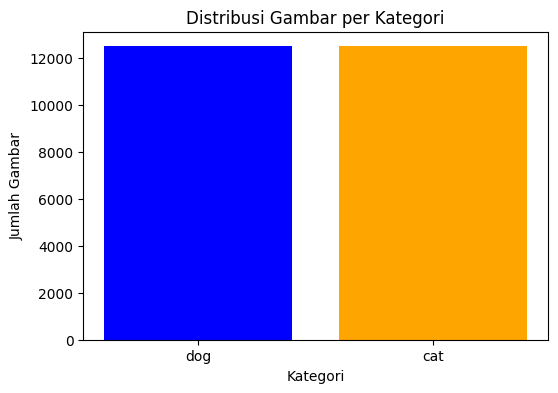

In [ ]:
num_images = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}

plt.figure(figsize=(6, 4))
plt.bar(num_images.keys(), num_images.values(), color=['blue', 'orange'])
plt.xlabel("Kategori")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Gambar per Kategori")
plt.show()

- Beberapa contoh gambar per kategori

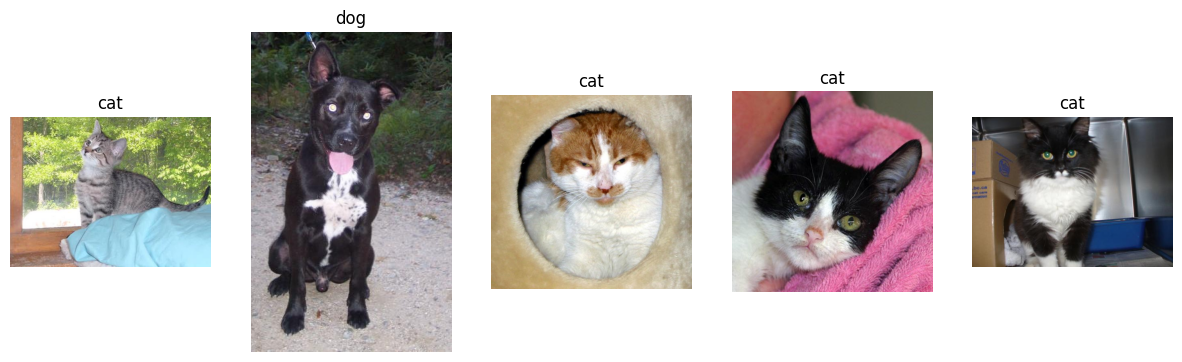

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax in axes:
    category = random.choice(categories)
    image_path = os.path.join(dataset_path, category, random.choice(os.listdir(os.path.join(dataset_path, category))))
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.set_title(category)
    ax.axis("off")

plt.show()

# Pemisahan Data (Data Splitting)

## 1. Inisiasi Folder untuk Splitting

In [ ]:
split_path = "split_dataset"

## 2. Proporsi data Splitting
80:10:10: Dalam skema ini, 80% dari data digunakan untuk pelatihan, 10% untuk validasi, dan 10% untuk pengujian

In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

## 3. Pembuatan folder untuk data Splitting

In [ ]:
for split in ["train", "val", "test"]:
    for category in os.listdir(dataset_path):
        os.makedirs(os.path.join(split_path, split, category), exist_ok=True)

## 4. Proses Splitting data

In [ ]:
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)
    random.shuffle(images)

    train_split = int(len(images) * train_ratio)
    val_split = int(len(images) * (train_ratio + val_ratio))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(split_path, "train", category, img))
    for img in val_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(split_path, "val", category, img))
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(split_path, "test", category, img))

print("Dataset berhasil dipisah (80% train, 10% validation, 10% test)")

Dataset berhasil dipisah (80% train, 10% validation, 10% test)


## 5. Pengecekan Splitting data

In [ ]:
split_path = "split_dataset"
splits = ["train", "val", "test"]
categories = os.listdir(os.path.join(split_path, "train"))
train_counts = [len(os.listdir(os.path.join(split_path, "train", category))) for category in categories]
val_counts = [len(os.listdir(os.path.join(split_path, "val", category))) for category in categories]
test_counts = [len(os.listdir(os.path.join(split_path, "test", category))) for category in categories]

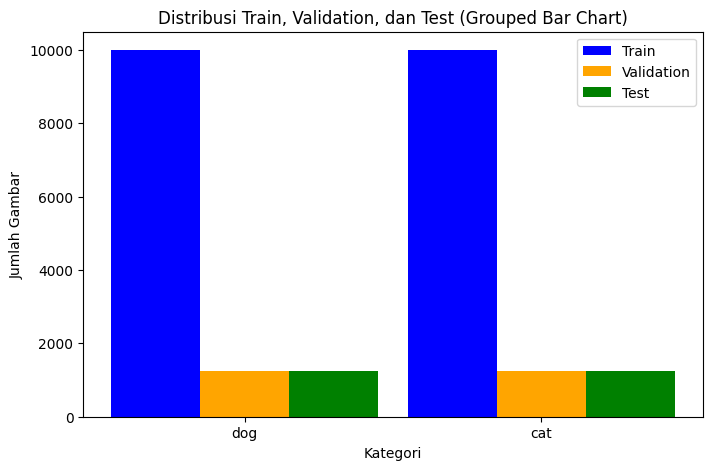

In [ ]:
x = np.arange(len(categories))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, train_counts, width, label="Train", color="blue")
ax.bar(x, val_counts, width, label="Validation", color="orange")
ax.bar(x + width, test_counts, width, label="Test", color="green")

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlabel("Kategori")
ax.set_ylabel("Jumlah Gambar")
ax.set_title("Distribusi Train, Validation, dan Test (Grouped Bar Chart)")
ax.legend()
plt.show()

# Pra-Pemrosesan Data Gambar

## Preprocessing (Resize + Normalisasi)

- Set ukuran gambar 

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

- Inisiasi Augmentasi data untuk training set

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

- Memuat data train

In [ ]:
train_data = train_datagen.flow_from_directory(
    "split_dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 19998 images belonging to 2 classes.


- Memuat data validation

In [ ]:
val_data = val_test_datagen.flow_from_directory(
    "split_dataset/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 2500 images belonging to 2 classes.


- Memuat data test

In [ ]:
test_data = val_test_datagen.flow_from_directory(
    "split_dataset/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 2500 images belonging to 2 classes.


- Labeling Kategori

In [ ]:
print(train_data.class_indices)

{'cat': 0, 'dog': 1}


### Visualisasi Augmentasi Gambar

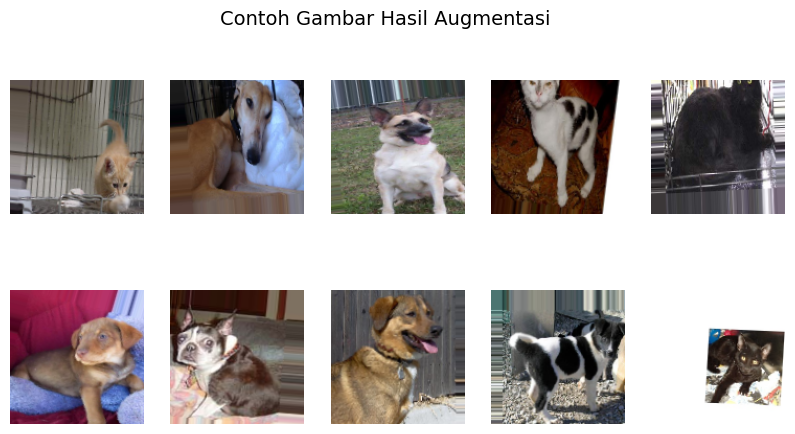

In [ ]:
images, labels = next(train_data)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

plt.suptitle("Contoh Gambar Hasil Augmentasi", fontsize=14)
plt.show()

# Pembuatan Model CNN

## 1. Bangun Arsitektur CNN

Pembuatan model menggunakan Conv2D, MaxPooling, Flatten, dan Dense.

- Def model Sequential

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_data.class_indices), activation='softmax')
])

/root/more/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-02 11:07:53.429021: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


- Ringkasan hasil model

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 2. Compile Model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 3. Training Model

- Callback untuk pengoptimalan trainig

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

- Pelatihan model

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

/root/more/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


319/625 ━━━━━━━━━━━━━━━━━━━━ 55s 183ms/step - accuracy: 0.5434 - loss: 0.6913

/root/more/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 199ms/step - accuracy: 0.5634 - loss: 0.6787 - val_accuracy: 0.6812 - val_loss: 0.6018 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 119s 190ms/step - accuracy: 0.6675 - loss: 0.6138 - val_accuracy: 0.7180 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 188ms/step - accuracy: 0.6985 - loss: 0.5761 - val_accuracy: 0.7652 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.7282 - loss: 0.5419 - val_accuracy: 0.7568 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 191ms/step - accuracy: 0.7533 - loss: 0.5106 - val_accuracy: 0.8036 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 197ms/step - accuracy: 0.7702 - loss: 0.4903 - val_accuracy: 0.8204 - val_loss: 0.4171 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 189s 302ms/step - accuracy: 0.7832 

## 4. Plot Akurasi & Loss

- Inisiasi hasil dari training

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

- Plot akurasi

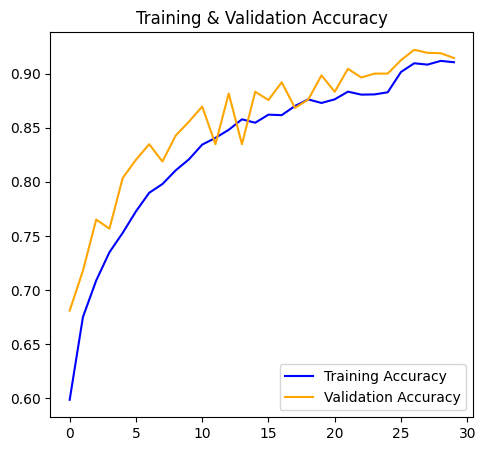

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')
plt.show()

- Plot Loss

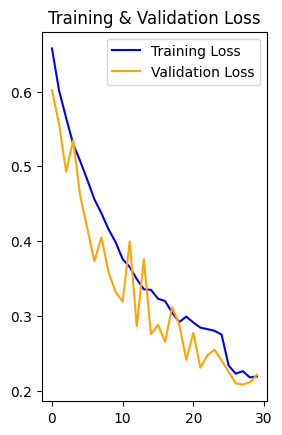

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

# 5. Evaluasi Model di Test Set

## 1. Classification Report (Precision, Recall, F1-Score)

- Prediksi untuk test set

In [ ]:
y_pred = model.predict(test_data)
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_data.classes

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step


- Hasil Report

In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))

              precision    recall  f1-score   support

         cat       0.94      0.90      0.92      1250
         dog       0.90      0.95      0.92      1250

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



- Confusion Matrix Visualisasi

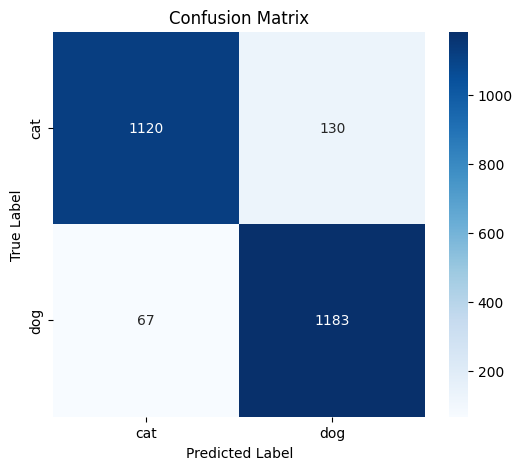

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Pengujian Model

### Pendapatan akurasi model

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"\nAkurasi Test Set: {test_acc:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8991 - loss: 0.2494

Akurasi Test Set: 0.9212


### Pengujian pada data test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


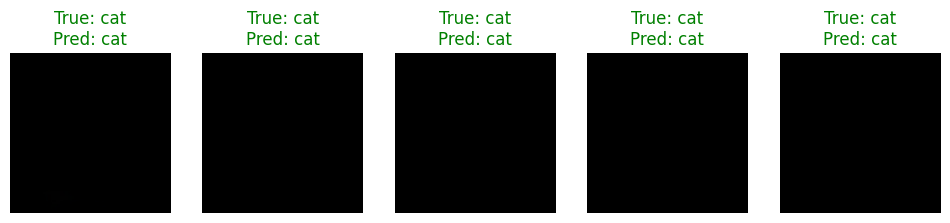

In [ ]:
num_samples = 5
sample_images, sample_labels = next(test_data)

sample_labels = np.argmax(sample_labels, axis=1)

predictions = model.predict(sample_images)
pred_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(sample_images[i].astype("uint8"))
    plt.axis("off")
    
    true_label = list(test_data.class_indices.keys())[sample_labels[i]]
    pred_label = list(test_data.class_indices.keys())[pred_labels[i]]
    
    plt.title(f"True: {true_label}\nPred: {pred_label}", 
              color="green" if true_label == pred_label else "red")

plt.show()

# Penyimpanan Model

In [ ]:
saved_model_path = "saved_model"

model.export(saved_model_path)

print(f"Model berhasil disimpan di: {saved_model_path}")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136354695343632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354695346704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354695347472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354695344400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354695346128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354695347856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354695346512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354695344016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354584887952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136354584889488: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil disimp

## Konversi Model ke TF-Lite

In [ ]:
tflite_model_path = "tflite/model.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")

tflite_model = converter.convert()

with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi ke TF-Lite: {tflite_model_path}")

Model berhasil dikonversi ke TF-Lite: tflite/model.tflite


W0000 00:00:1740921821.478832     771 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1740921821.478851     771 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-02 13:23:41.479045: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-03-02 13:23:41.480016: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-02 13:23:41.480035: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: saved_model
2025-03-02 13:23:41.487384: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-02 13:23:41.541510: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: saved_model
2025-03-02 13:23:41.556047: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 77007 microseconds.


### Simpan Label Kelas

In [ ]:
label_path = "tflite/label.txt"

class_labels = list(train_data.class_indices.keys())

with open(label_path, "w") as f:
    for label in class_labels:
        f.write(f"{label}\n")

print(f"Label kelas disimpan di: {label_path}")

Label kelas disimpan di: tflite/label.txt


## 3. Konversi Model ke TFJS

In [ ]:
tfjs_model_path = "tfjs_model"

tfjs.converters.convert_tf_saved_model("saved_model", tfjs_model_path)

print(f"Model berhasil dikonversi ke TFJS: {tfjs_model_path}")

I0000 00:00:1740921840.751869     771 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1740921840.752002     771 single_machine.cc:361] Starting new session


Model berhasil dikonversi ke TFJS: tfjs_model
